In [1]:
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc
from seffaflik.elektrik.piyasalar import dgp, gop
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from seffaflik.elektrik import uretim
from lightgbm.sklearn import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
from smtplib import SMTP
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email.utils import formatdate
from email import encoders

In [2]:
#%% Initialize LightGBMClassifier

def LGBClassifier(X_train,y_train,X_test):
    
    space = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
             'max_depth': np.arange(1, 20, 4),
             'n_estimators': np.arange(5, 100, 20),
             'num_leaves': np.arange(5, 50, 10),
             'min_child_weight': [6, 8],
             'reg_lambda': [0.0, 1.0]
             }

    gsearch1 = GridSearchCV(estimator = LGBMClassifier(), param_grid = space, n_jobs=-1, scoring='accuracy')
    gsearch1.fit(X_train,y_train)
    # Printing best parameters
    print(gsearch1.best_params_)
    print(gsearch1.best_score_)
    Xgbpred = gsearch1.predict(X_test)
    return gsearch1, Xgbpred


In [3]:
#%% Initialize ConfusionMatrix

def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_val, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['YAT','YAL']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1 Score={0:0.3f}'.format(F1))

In [4]:
#%% Initialize AUC

def plot_aucprc(y_val, pred):
    
    fpr, tpr, thresholds_en = roc_curve(y_val, pred)
    roc_auc_result = auc(fpr, tpr)
    precision, recall, th = precision_recall_curve(y_val, pred)
    average_precision = average_precision_score(y_val, pred)

    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print('AUC Score:', roc_auc_result)
    
    #Plotting
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = %0.3f' % roc_auc_result)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    return roc_auc_result

In [5]:
#%%####################################
############ DATA CURATION ############
#######################################

# Creating DateTime
today = datetime.today().strftime('%Y-%m-%d')
tomorrow = (datetime.now() + timedelta(1)).strftime('%Y-%m-%d')
tomorrow2 = (datetime.now() + timedelta(2)).strftime('%Y-%m-%d')
yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')

rng = pd.date_range(pd.to_datetime('2019-03-05'), pd.to_datetime('2021-05-05'), freq='H')
rng = pd.DataFrame(rng[0:-1]).set_axis(['DateTime'], axis=1)

rng_test = pd.date_range(tomorrow, tomorrow2, freq='H')
rng_test = pd.DataFrame(rng_test[0:-1]).set_axis(['DateTime'], axis=1)

In [6]:
#%% RES Tahmin
def get_WindGenerationForecast(start_date, end_date, value):
    down = './test.json'
    url = 'https://seffaflik.epias.com.tr/transparency/service/production/wpp-generation-and-forecast?endDate={}&startDate={}'.format(end_date,start_date)
    outpath=down
    generatedURL=url
    response = requests.get(generatedURL)
    if response.status_code == 200:
        with open(outpath, "wb") as out:
            for chunk in response.iter_content(chunk_size=128):
                out.write(chunk)
    with open(down) as json_file:
        data = json.load(json_file)
    body=data.get('body')
    gen=body.get('data')
    df=pd.DataFrame(gen)
    df['DateTime'] = pd.to_datetime(df['effectiveDate']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df["DateTime"] = df["DateTime"].astype("datetime64[ns]")
    df = df.set_index('DateTime')
    df = pd.DataFrame(df[value])
    df = df.reset_index()
    return df

wind_train = get_WindGenerationForecast('2019-03-05', '2021-05-04', "generation")
wind_train.head()


,DateTime,generation
0,2019-03-05 00:00:00,653.453
1,2019-03-05 01:00:00,824.797
2,2019-03-05 02:00:00,892.950
3,2019-03-05 03:00:00,973.000
4,2019-03-05 04:00:00,1071.253


In [7]:
#%% SMF VE SİSTEM YÖNÜ
def get_smf(start_date, end_date):
    smf1 = dgp.smf(baslangic_tarihi = start_date, bitis_tarihi = end_date)
    smf1['DateTime'] = pd.to_datetime(smf1.Tarih) + smf1.Saat.astype('timedelta64[h]')
    smf1 = smf1.set_index('DateTime')

    dictionary = {"YAL" : 1, "DNG" : np.nan, "YAT" : 0}
    smf1 = smf1.replace({'Sistem Yönü': dictionary})
    smf1 = smf1.drop(['Tarih','Saat'], axis = 1)
    return smf1

smf_train = get_smf('2019-03-05', '2021-05-04')
smf_train.head()


,SMF,Sistem Yönü
DateTime,,
2019-03-05 00:00:00,288.48,0.0
2019-03-05 01:00:00,290.00,0.0
2019-03-05 02:00:00,284.63,NaN
2019-03-05 03:00:00,280.00,NaN
2019-03-05 04:00:00,223.32,NaN


In [8]:
#%% PTF 
def get_ptf(start_date, end_date):
    ptf1 = gop.ptf(baslangic_tarihi = start_date, bitis_tarihi = end_date)
    ptf1['DateTime'] = pd.to_datetime(ptf1.Tarih) + ptf1.Saat.astype('timedelta64[h]')
    ptf1 = ptf1.set_index('DateTime')
    ptf1 = pd.DataFrame(ptf1['PTF'])
    return ptf1

ptf_train = get_ptf('2019-03-05', '2021-05-04')
ptf_train.head()


,PTF
DateTime,
2019-03-05 00:00:00,288.48
2019-03-05 01:00:00,290.49
2019-03-05 02:00:00,284.63
2019-03-05 03:00:00,280.00
2019-03-05 04:00:00,223.32


In [9]:
#%% KGÜP
def get_kgup(start_date, end_date):
    kgup2 = uretim.kgup(baslangic_tarihi = start_date, bitis_tarihi = end_date)
    kgup2['DateTime'] = pd.to_datetime(kgup2.Tarih) + kgup2.Saat.astype('timedelta64[h]')
    kgup2 = kgup2.set_index('DateTime')
    kgup2 = pd.DataFrame(kgup2['Toplam'])
    kgup2.columns = ['KGUP']
    return kgup2

kgup_train = get_kgup('2019-03-05', '2021-05-04')
kgup_train.head()


,KGUP
DateTime,
2019-03-05 00:00:00,29266.73
2019-03-05 01:00:00,26959.48
2019-03-05 02:00:00,26068.73
2019-03-05 03:00:00,25270.18
2019-03-05 04:00:00,25000.15


In [10]:
#%% EAK
def get_eak(start_date, end_date):
    eak2 = uretim.eak(baslangic_tarihi = start_date, bitis_tarihi = end_date)
    eak2['DateTime'] = pd.to_datetime(eak2.Tarih) + eak2.Saat.astype('timedelta64[h]')
    eak2 = eak2.set_index('DateTime')
    eak2 = pd.DataFrame(eak2['Toplam'])
    eak2.columns = ['EAK']
    return eak2

eak_train = get_eak('2019-03-05', '2021-05-04')
eak_train.head()


,EAK
DateTime,
2019-03-05 00:00:00,57640.72
2019-03-05 01:00:00,57743.55
2019-03-05 02:00:00,57751.95
2019-03-05 03:00:00,57998.47
2019-03-05 04:00:00,58041.89


In [11]:
#%% MERGING

wind_train = pd.merge(wind_train, rng, on="DateTime", how="outer")
df = pd.merge(smf_train, wind_train, on="DateTime", how="outer")
df = pd.merge(df, ptf_train, on="DateTime", how="outer")
df = pd.merge(df, kgup_train, on="DateTime", how="outer")
df = pd.merge(df, eak_train, on="DateTime", how="outer")

df['hour'] = pd.DatetimeIndex(df['DateTime']).hour
df['day'] = pd.DatetimeIndex(df['DateTime']).day
df['month'] = pd.DatetimeIndex(df['DateTime']).month
df['dayofweek'] = pd.DatetimeIndex(df['DateTime']).dayofweek

In [12]:
#%% Supply Demand

supplydemand = pd.read_excel('YönTahminVerisi.xlsx',index_col='DateTime',parse_dates=True)
supplydemand = supplydemand.loc['2019-03-05':'2021-05-04']
supplydemand = supplydemand.drop(['wind','ptf','smf','temp','gun_tipi','pbs'], axis = 1)
supplydemand = supplydemand.reset_index(drop=False)

df = pd.merge(df, supplydemand, on="DateTime", how="outer")

In [13]:
"""Analyzing missing values in data"""
print(df.shape)
df.isnull().sum()
percent_missing = df.isnull(). sum() * 100 / len(df)
print("Percentage of missing values in each column:\n",percent_missing)
df = df.dropna(axis='rows')
print(df.shape)

(19008, 13)
Percentage of missing values in each column:
 DateTime       0.000000
SMF            0.000000
Sistem Yönü    4.398148
generation     1.972854
PTF            0.000000
KGUP           0.000000
EAK            0.000000
hour           0.000000
day            0.000000
month          0.000000
dayofweek      0.000000
demand         0.000000
supply         0.000000
dtype: float64
(17810, 13)


In [14]:
"""Checking columns names"""
print(df.columns)

Index(['DateTime', 'SMF', 'Sistem Yönü', 'generation', 'PTF', 'KGUP', 'EAK',
       'hour', 'day', 'month', 'dayofweek', 'demand', 'supply'],
      dtype='object')


In [15]:
df.head(10)

,DateTime,SMF,Sistem Yönü,generation,PTF,KGUP,EAK,hour,day,month,dayofweek,demand,supply
0,2019-03-05 00:00:00,288.48,0.0,653.453,288.48,29266.73,57640.72,0,5,3,1,31900,29266.73
1,2019-03-05 01:00:00,290.00,0.0,824.797,290.49,26959.48,57743.55,1,5,3,1,29800,26959.48
5,2019-03-05 05:00:00,280.00,0.0,1242.003,299.98,25721.17,58270.17,5,5,3,1,28300,25721.17
6,2019-03-05 06:00:00,267.49,0.0,1323.608,287.49,26618.48,58254.69,6,5,3,1,29900,26618.48
7,2019-03-05 07:00:00,295.60,0.0,1399.933,320.60,28700.24,58006.07,7,5,3,1,31800,28700.24
8,2019-03-05 08:00:00,285.90,0.0,1533.022,325.75,33055.83,58237.01,8,5,3,1,36000,33055.83
9,2019-03-05 09:00:00,290.00,0.0,1510.768,327.38,35136.10,58057.20,9,5,3,1,38800,35136.10
10,2019-03-05 10:00:00,280.00,0.0,1506.380,326.34,35164.57,58088.00,10,5,3,1,39000,35164.57
11,2019-03-05 11:00:00,270.00,0.0,1466.673,327.28,34972.66,58083.14,11,5,3,1,39300,34972.66
12,2019-03-05 12:00:00,270.00,0.0,1641.150,299.97,32977.97,58089.29,12,5,3,1,37600,32977.97


In [16]:
df.tail(10)

,DateTime,SMF,Sistem Yönü,generation,PTF,KGUP,EAK,hour,day,month,dayofweek,demand,supply
18998,2021-05-04 14:00:00,428.61,1.0,2784.170,367.61,32627.01,57092.17,14,4,5,1,40383,32627.01
18999,2021-05-04 15:00:00,452.16,1.0,3007.848,364.16,32441.83,57169.32,15,4,5,1,39779,32441.83
19000,2021-05-04 16:00:00,449.01,1.0,3372.067,354.01,32508.01,57847.38,16,4,5,1,38784,32508.01
19001,2021-05-04 17:00:00,445.71,1.0,3384.877,355.71,33108.26,58090.18,17,4,5,1,37727,33108.26
19002,2021-05-04 18:00:00,413.68,1.0,3516.345,363.68,33862.73,58417.14,18,4,5,1,36972,33862.73
19003,2021-05-04 19:00:00,399.99,1.0,3677.577,370.75,34451.68,58517.84,19,4,5,1,37417,34451.68
19004,2021-05-04 20:00:00,358.64,0.0,3485.918,368.64,34288.52,58514.49,20,4,5,1,37081,34288.52
19005,2021-05-04 21:00:00,404.99,1.0,3308.723,370.37,34421.28,58496.76,21,4,5,1,37205,34421.28
19006,2021-05-04 22:00:00,399.99,1.0,3228.442,366.17,33501.73,58568.31,22,4,5,1,36513,33501.73
19007,2021-05-04 23:00:00,394.91,1.0,2427.002,360.91,32446.67,58544.72,23,4,5,1,35242,32836.67


In [17]:
df.sample(10)

,DateTime,SMF,Sistem Yönü,generation,PTF,KGUP,EAK,hour,day,month,dayofweek,demand,supply
16081,2021-01-03 01:00:00,293.29,0.0,919.527,312.06,25987.24,59360.48,1,3,1,6,30732,25987.24
11181,2020-06-12 21:00:00,237.93,0.0,1073.132,323.82,32113.12,60023.45,21,12,6,4,34476,32113.12
18821,2021-04-27 05:00:00,355.01,1.0,1402.862,325.01,27848.70,57350.38,5,27,4,1,30461,27848.70
6432,2019-11-28 00:00:00,350.00,1.0,401.560,315.57,27697.95,56698.50,0,28,11,3,31400,27697.95
8181,2020-02-08 21:00:00,403.32,1.0,2391.883,330.26,33252.68,56537.75,21,8,2,5,36240,33252.68
1319,2019-04-28 23:00:00,200.00,1.0,544.140,169.99,26441.55,53600.34,23,28,4,6,30000,26441.55
1219,2019-04-24 19:00:00,350.00,1.0,754.417,303.85,31845.15,55845.30,19,24,4,2,35600,31845.15
9989,2020-04-24 05:00:00,299.99,1.0,2889.478,198.78,20314.77,54646.71,5,24,4,4,21852,20314.77
17728,2021-03-12 16:00:00,334.41,1.0,1345.502,334.41,33762.51,59200.62,16,12,3,4,40619,33762.51
239,2019-03-14 23:00:00,305.00,1.0,739.140,299.49,30843.69,57574.46,23,14,3,3,32800,30843.69


1.0    10296
0.0     7514
Name: Sistem Yönü, dtype: int64


Text(0, 0.5, 'Frequency')

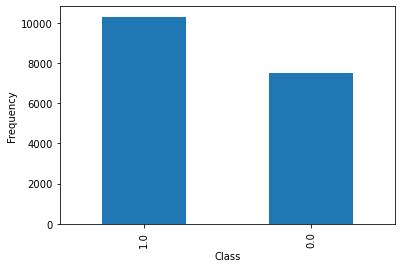

In [18]:
"Checking Target of the data"
print(df['Sistem Yönü'].value_counts())
pd.value_counts(df['Sistem Yönü']).plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')


In [19]:
"""Checking whether the data includes categorical values"""
categorical = [var for var in df.columns if df[var].dtype=='O']
print('The categorical variables are :', categorical)


The categorical variables are : []


In [20]:
"""Finding numerical variables"""
numerical = [var for var in df.columns if df[var].dtype!='O']
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)
df[numerical].head()

There are 13 numerical variables

The numerical variables are : ['DateTime', 'SMF', 'Sistem Yönü', 'generation', 'PTF', 'KGUP', 'EAK', 'hour', 'day', 'month', 'dayofweek', 'demand', 'supply']


,DateTime,SMF,Sistem Yönü,generation,PTF,KGUP,EAK,hour,day,month,dayofweek,demand,supply
0,2019-03-05 00:00:00,288.48,0.0,653.453,288.48,29266.73,57640.72,0,5,3,1,31900,29266.73
1,2019-03-05 01:00:00,290.00,0.0,824.797,290.49,26959.48,57743.55,1,5,3,1,29800,26959.48
5,2019-03-05 05:00:00,280.00,0.0,1242.003,299.98,25721.17,58270.17,5,5,3,1,28300,25721.17
6,2019-03-05 06:00:00,267.49,0.0,1323.608,287.49,26618.48,58254.69,6,5,3,1,29900,26618.48
7,2019-03-05 07:00:00,295.60,0.0,1399.933,320.60,28700.24,58006.07,7,5,3,1,31800,28700.24


<AxesSubplot:>

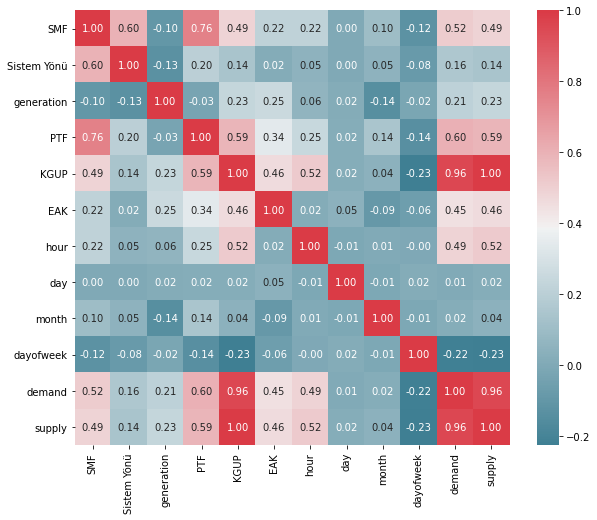

In [21]:
"Correlation matrix"
df = df.set_index("DateTime")
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), mask=np.zeros_like(df.corr(), dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, fmt='.2f',annot=True)

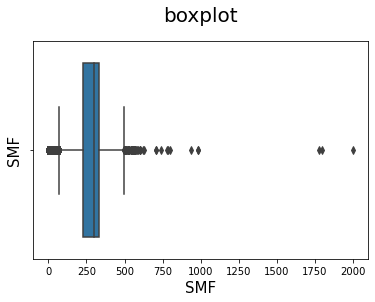

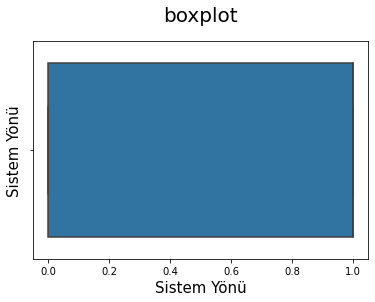

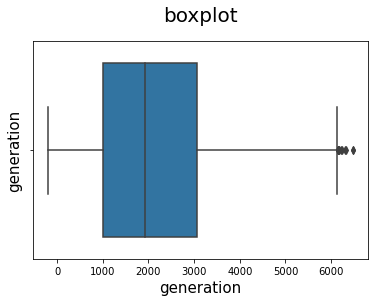

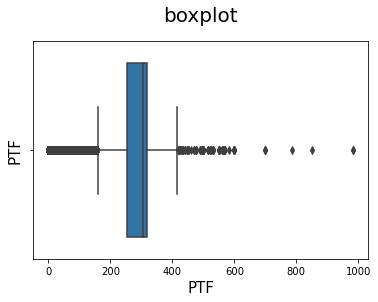

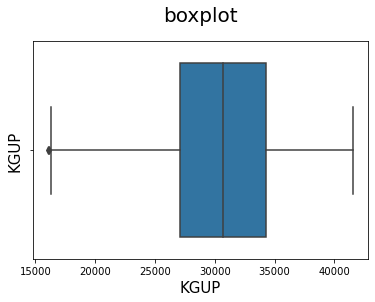

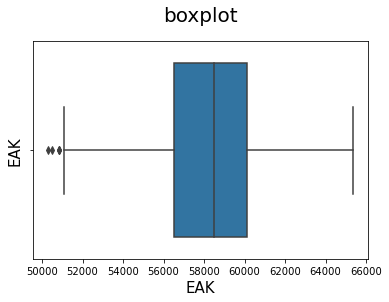

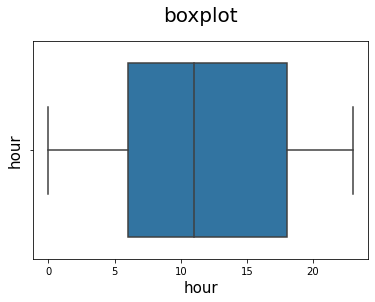

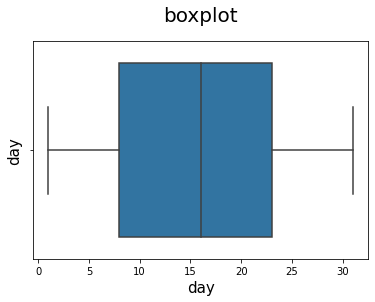

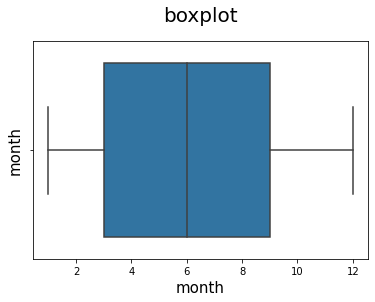

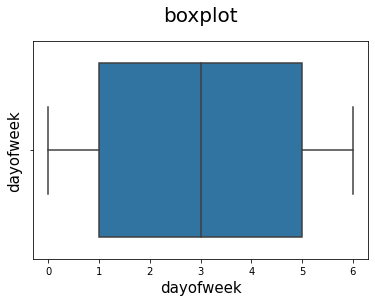

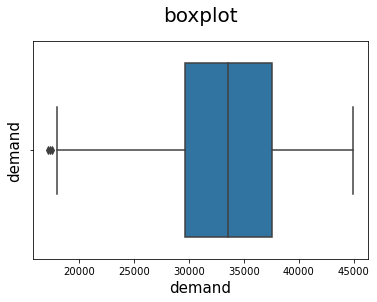

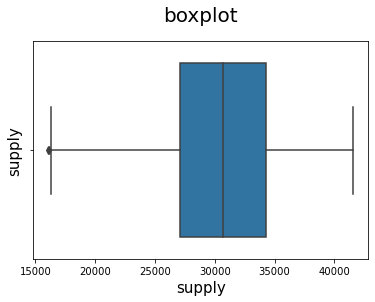

In [22]:
"Creating the BoxPlot"
for feature in df.columns:
    ax = sns.boxplot(x = df[feature])
    ax.set_xlabel(feature, fontsize = 15)
    ax.set_ylabel(feature, fontsize = 15)
    ax.set_title("boxplot", fontsize =20, pad = 20)
    plt.show()

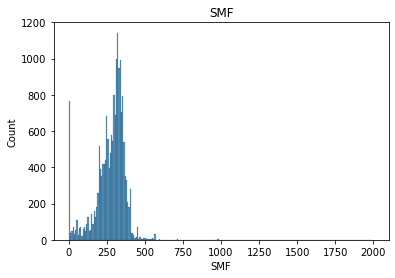

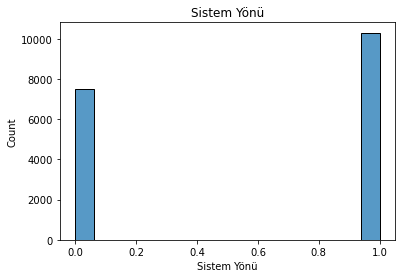

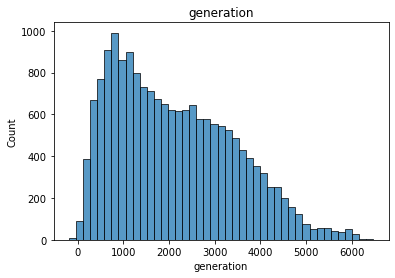

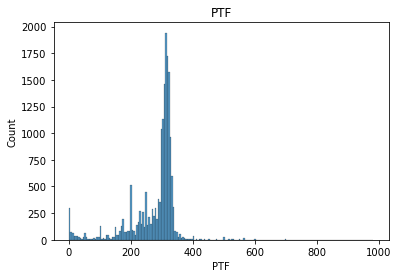

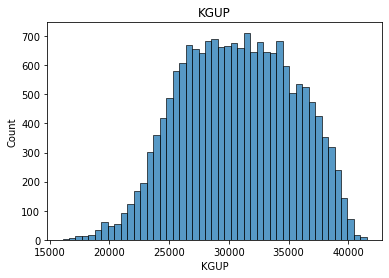

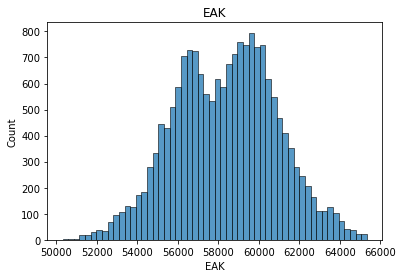

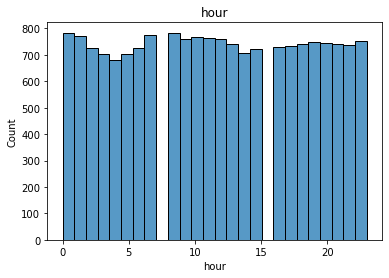

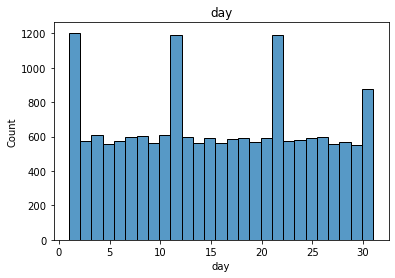

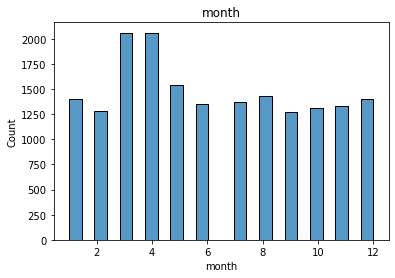

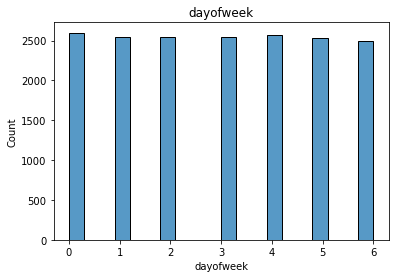

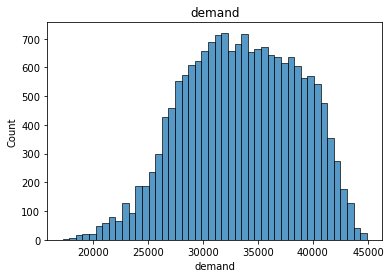

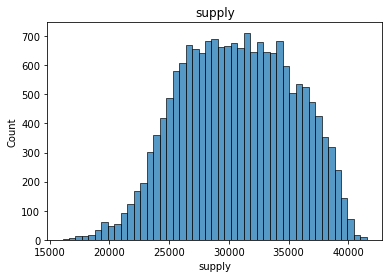

In [23]:
"Creating the histograms"
for feature in df.columns:
    sns.histplot(data=df, x=feature).set(title=feature)
    plt.show()

In [24]:
"Creating correlation matrix features without target value"
olddf = df.columns
print("Before eliminating shape: ",df.shape)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Keeping at least any feature in data.
to_drop = [column for column in upper.columns if any(upper[column] > 0.94)]
# Dropping index of feature columns with correlation greater than 0.94
df = df.drop(df[to_drop], axis=1)
newdf = df.columns
print("After eliminating shape: ",df.shape)
print("Eliminating features:\n",list(set(olddf) - set(newdf)))

Before eliminating shape:  (17810, 12)
After eliminating shape:  (17810, 10)
Eliminating features:
 ['demand', 'supply']


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [   0    1    2 ... 2967 2968 2969] VALIDATION: [2970 2971 2972 ... 5935 5936 5937]
{'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 6, 'n_estimators': 25, 'num_leaves': 15, 'reg_lambda': 0.0}
0.937037037037037


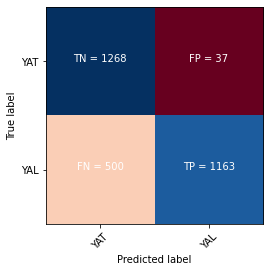

Recall=0.699 
Precision=0.969
F1 Score=0.812
Average precision-recall score: 0.846
AUC Score: 0.8354930271885505


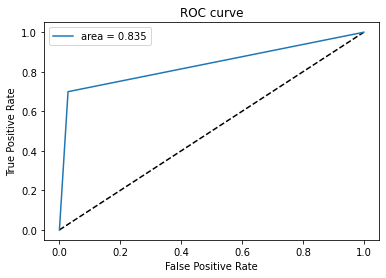

TRAIN: [   0    1    2 ... 5935 5936 5937] VALIDATION: [5938 5939 5940 ... 8903 8904 8905]
{'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 6, 'n_estimators': 25, 'num_leaves': 45, 'reg_lambda': 1.0}
0.9479622112730791


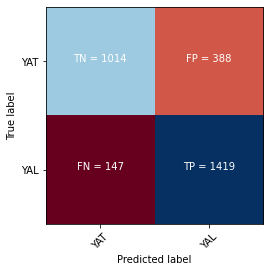

Recall=0.906 
Precision=0.785
F1 Score=0.841
Average precision-recall score: 0.761
AUC Score: 0.8146913823164499


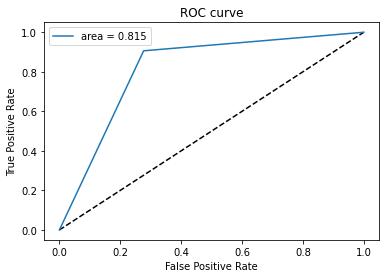

TRAIN: [   0    1    2 ... 8903 8904 8905] VALIDATION: [ 8906  8907  8908 ... 11871 11872 11873]
{'learning_rate': 0.1, 'max_depth': 17, 'min_child_weight': 6, 'n_estimators': 25, 'num_leaves': 45, 'reg_lambda': 0.0}
0.9555380368032436


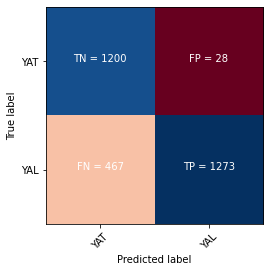

Recall=0.732 
Precision=0.978
F1 Score=0.837
Average precision-recall score: 0.873
AUC Score: 0.8544039462353513


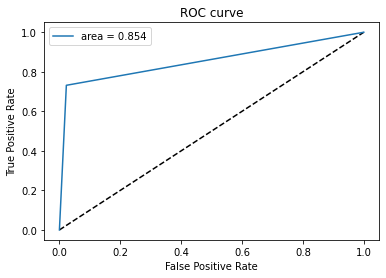

TRAIN: [    0     1     2 ... 11871 11872 11873] VALIDATION: [11874 11875 11876 ... 14839 14840 14841]
{'learning_rate': 0.1, 'max_depth': 17, 'min_child_weight': 6, 'n_estimators': 25, 'num_leaves': 45, 'reg_lambda': 0.0}
0.9592398350552033


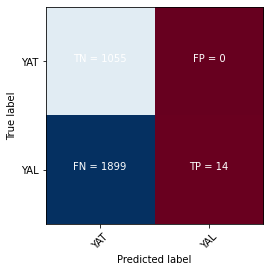

Recall=0.007 
Precision=1.000
F1 Score=0.015
Average precision-recall score: 0.647
AUC Score: 0.503659174072138


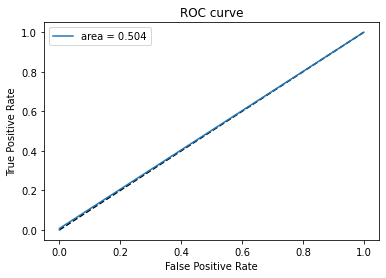

TRAIN: [    0     1     2 ... 14839 14840 14841] VALIDATION: [14842 14843 14844 ... 17807 17808 17809]
{'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 25, 'num_leaves': 45, 'reg_lambda': 0.0}
0.9592382062988708


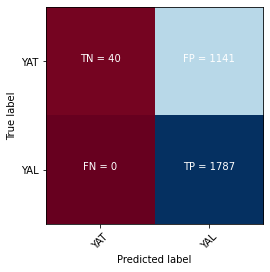

Recall=1.000 
Precision=0.610
F1 Score=0.758
Average precision-recall score: 0.610
AUC Score: 0.5169348010160881


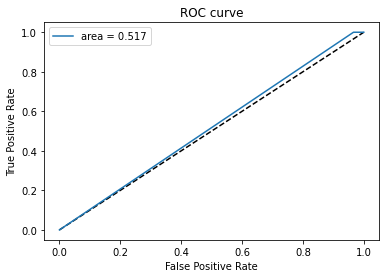

Accuracy Results:
 [0.8190700808625337, 0.819743935309973, 0.8332210242587601, 0.36017520215633425, 0.6155660377358491]
AUC Results:
 [0.8354930271885505, 0.8146913823164499, 0.8544039462353513, 0.503659174072138, 0.5169348010160881]


In [25]:
#%% Creating TimeSeriesSplit, Validation set and Training set
Target = df['Sistem Yönü']
Target = pd.DataFrame(Target)
df = df.drop('Sistem Yönü', axis=1)

df = df.values
Target = Target.values

sc_X = MinMaxScaler()
sc_y = MinMaxScaler()

k = 0
n_splits=5

tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
predictions = pd.DataFrame(columns=np.arange(0,5,1)).fillna(0)
accuracyresults = np.zeros(n_splits)
aucscoreresults = np.zeros(n_splits)
X_train_append = []
y_train_append = []
X_val_append = []
y_val_append = []
print(tscv)
for train_index, val_index in tscv.split(df):
    print("TRAIN:", train_index, "VALIDATION:", val_index)    
    X_train, X_val = df[train_index], df[val_index]
    y_train, y_val = Target[train_index], Target[val_index]
    X_train_scaled = sc_X.fit_transform(X_train)
    X_val_scaled = sc_y.fit_transform(X_val)
    X_train_append.append(X_train_scaled), y_train_append.append(y_train), X_val_append.append(X_val_scaled), y_val_append.append(y_val)
    model, predictions[k] = LGBClassifier(X_train_scaled,y_train.ravel(),X_val_scaled)
    # scores = model.predict_proba(X_val_scaled)[:,1]
    
    #Plotting
    plot_cm(model, predictions[k])
    aucscore = plot_aucprc(y_val, predictions[k]) 
    accuracyresults[k] = metrics.accuracy_score(y_val, predictions[k])
    aucscoreresults[k] = aucscore
    k = k + 1
    
accuracyresults = list(accuracyresults)
aucscoreresults = list(aucscoreresults)
print("Accuracy Results:\n", accuracyresults)
print("AUC Results:\n",aucscoreresults)


In [26]:
#%%####################################
############## TEST SET  ##############
#######################################

wind_test = get_WindGenerationForecast(tomorrow, tomorrow, "forecast")
wind_train.head()

,DateTime,generation
0,2019-03-05 00:00:00,653.453
1,2019-03-05 01:00:00,824.797
2,2019-03-05 02:00:00,892.950
3,2019-03-05 03:00:00,973.000
4,2019-03-05 04:00:00,1071.253


In [27]:
#%% SMF VE SİSTEM YÖNÜ

smf_test = get_smf(yesterday, yesterday)
smf_test = smf_test.drop(['Sistem Yönü'], axis = 1)
smf_test = smf_test.reset_index(drop=True)
smf_test["DateTime"] = rng_test
smf_test = smf_test.set_index("DateTime")
smf_test.head()

,SMF
DateTime,
2022-03-16 00:00:00,1745.00
2022-03-16 01:00:00,1745.00
2022-03-16 02:00:00,1745.00
2022-03-16 03:00:00,1649.01
2022-03-16 04:00:00,1496.47


In [28]:
#%% PTF 
ptf_test = get_ptf(tomorrow, tomorrow)
ptf_test.head()

,PTF
DateTime,
2022-03-16 00:00:00,1745
2022-03-16 01:00:00,1745
2022-03-16 02:00:00,1745
2022-03-16 03:00:00,1745
2022-03-16 04:00:00,1745


In [29]:
#%% KGÜP
kgup_test = get_kgup(tomorrow, tomorrow)
kgup_test.head()

,KGUP
DateTime,
2022-03-16 00:00:00,28431.69
2022-03-16 01:00:00,26893.97
2022-03-16 02:00:00,26015.07
2022-03-16 03:00:00,25486.36
2022-03-16 04:00:00,25111.05


In [30]:
#%% EAK
eak_test = get_eak(tomorrow, tomorrow)
eak_test.head()

,EAK
DateTime,
2022-03-16 00:00:00,55083.84
2022-03-16 01:00:00,54814.73
2022-03-16 02:00:00,54688.23
2022-03-16 03:00:00,54651.95
2022-03-16 04:00:00,54651.79


In [31]:
#%% MERGING
X_test = pd.merge(smf_test, wind_test, on="DateTime", how="outer")
X_test = pd.merge(X_test, ptf_test, on="DateTime", how="outer")
X_test = pd.merge(X_test, kgup_test, on="DateTime", how="outer")
X_test = pd.merge(X_test, eak_test, on="DateTime", how="outer")

X_test = X_test.reset_index(drop=False)

X_test['hour'] = pd.DatetimeIndex(X_test['DateTime']).hour
X_test['day'] = pd.DatetimeIndex(X_test['DateTime']).day
X_test['month'] = pd.DatetimeIndex(X_test['DateTime']).month
X_test['dayofweek'] = pd.DatetimeIndex(X_test['DateTime']).dayofweek

X_test = X_test.set_index('DateTime')
X_test = X_test.drop(['index'], axis = 1)

In [32]:
"""Analyzing missing values in values"""
print(X_test.shape)
X_test.isnull().sum()
X_test = X_test.dropna(axis='rows')
print(X_test.shape)

(24, 9)
(24, 9)


In [33]:
"""Checking columns names"""
print(X_test.columns)

Index(['SMF', 'forecast', 'PTF', 'KGUP', 'EAK', 'hour', 'day', 'month',
       'dayofweek'],
      dtype='object')


In [34]:
X_test.head(10)

,SMF,forecast,PTF,KGUP,EAK,hour,day,month,dayofweek
DateTime,,,,,,,,,
2022-03-16 00:00:00,1745.00,2281.000,1745,28431.69,55083.84,0,16,3,2
2022-03-16 01:00:00,1745.00,2169.730,1745,26893.97,54814.73,1,16,3,2
2022-03-16 02:00:00,1745.00,2054.942,1745,26015.07,54688.23,2,16,3,2
2022-03-16 03:00:00,1649.01,1925.210,1745,25486.36,54651.95,3,16,3,2
2022-03-16 04:00:00,1496.47,1811.305,1745,25111.05,54651.79,4,16,3,2
2022-03-16 05:00:00,1595.01,1709.818,1745,24991.35,54696.74,5,16,3,2
2022-03-16 06:00:00,1745.00,1618.848,1745,25333.37,55133.83,6,16,3,2
2022-03-16 07:00:00,1745.00,1542.408,1745,27253.09,57525.52,7,16,3,2
2022-03-16 08:00:00,1745.00,1429.673,1745,29639.92,59525.15,8,16,3,2


In [35]:
X_test.tail(10)

,SMF,forecast,PTF,KGUP,EAK,hour,day,month,dayofweek
DateTime,,,,,,,,,
2022-03-16 14:00:00,1745.0,1205.283,1745,32024.33,60907.18,14,16,3,2
2022-03-16 15:00:00,1745.0,1220.778,1745,32097.27,60992.94,15,16,3,2
2022-03-16 16:00:00,1745.0,1181.835,1745,32306.71,60783.60,16,16,3,2
2022-03-16 17:00:00,1745.0,1031.835,1745,32866.01,60725.67,17,16,3,2
2022-03-16 18:00:00,1745.0,908.128,1745,32444.20,60709.06,18,16,3,2
2022-03-16 19:00:00,1745.0,910.817,1745,33448.16,60715.70,19,16,3,2
2022-03-16 20:00:00,1745.0,879.888,1745,32318.50,59814.04,20,16,3,2
2022-03-16 21:00:00,1745.0,866.712,1745,31686.29,59335.13,21,16,3,2
2022-03-16 22:00:00,1745.0,894.660,1745,31459.99,57483.65,22,16,3,2


In [36]:
X_test.sample(10)

,SMF,forecast,PTF,KGUP,EAK,hour,day,month,dayofweek
DateTime,,,,,,,,,
2022-03-16 19:00:00,1745.00,910.817,1745,33448.16,60715.70,19,16,3,2
2022-03-16 03:00:00,1649.01,1925.210,1745,25486.36,54651.95,3,16,3,2
2022-03-16 02:00:00,1745.00,2054.942,1745,26015.07,54688.23,2,16,3,2
2022-03-16 07:00:00,1745.00,1542.408,1745,27253.09,57525.52,7,16,3,2
2022-03-16 22:00:00,1745.00,894.660,1745,31459.99,57483.65,22,16,3,2
2022-03-16 08:00:00,1745.00,1429.673,1745,29639.92,59525.15,8,16,3,2
2022-03-16 00:00:00,1745.00,2281.000,1745,28431.69,55083.84,0,16,3,2
2022-03-16 13:00:00,1745.00,1186.198,1745,31564.78,60718.29,13,16,3,2
2022-03-16 04:00:00,1496.47,1811.305,1745,25111.05,54651.79,4,16,3,2


In [37]:
#%% Predictions
X_test_scaled = sc_X.fit_transform(X_test)

modeltest, result = LGBClassifier(X_train_append[aucscoreresults.index(max(list(aucscoreresults)))],
                                  y_train_append[aucscoreresults.index(max(list(aucscoreresults)))].ravel(), X_test_scaled)

print(result)
result = pd.DataFrame(result)
result_tomorrow = pd.merge(result, rng_test, left_index=True, right_index=True)
result_tomorrow = result_tomorrow.set_index("DateTime")
result_tomorrow["Sistem Yönü"] = 0
for i in range(len(result_tomorrow)):
    if result_tomorrow[0].iloc[i] == 1.0:
        result_tomorrow["Sistem Yönü"].iloc[i] = "YAL"
    else:
        result_tomorrow["Sistem Yönü"].iloc[i] = "YAT"

scorestest = modeltest.predict_proba(X_test_scaled)[:,1]
result_tomorrow["Olasılık"] = scorestest

{'learning_rate': 0.1, 'max_depth': 17, 'min_child_weight': 6, 'n_estimators': 25, 'num_leaves': 45, 'reg_lambda': 0.0}
0.9555380368032436
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/toygar/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


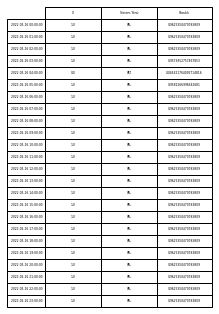

In [38]:
#%% EXPORTING PDF
fig, ax =plt.subplots(figsize=(3,1))
ax.axis('off')
the_table = ax.table(cellText = result_tomorrow.values, rowLabels = result_tomorrow.index, loc='center', colLabels = result_tomorrow.columns, cellLoc='center')
the_table.set_fontsize(15)
plt.savefig("SystemDirection.pdf", format="pdf", bbox_inches = 'tight')

In [39]:
#%% Sending Mail

tomorrow_mail = (datetime.now() + timedelta(1)).strftime('%d-%m-%Y')

def send_mail(date,username,password):
        isTls=True
        subject = "{} Sistem Yön Raporu".format(date)
        text = "Merhabalar,\n\n{} Sistem Yön Tahmini ektedir.\n\nSaygılarımla\nToygar Ülgen".format(date)
        server = SMTP('smtp.office365.com', 587)
        msg = MIMEMultipart()
        msg['From'] = username
        cc=["mustafa.cetin@nykenerji.com"]
        to=["cagri.levent@nykenerji.com","bedriye.bicak@nykenerji.com",
            "enes.ozturk@nykenerji.com","dogukan.aktas@nykenerji.com",
            "fatih.er@nykenerji.com","merve.akca@nykenerji.com"]
        msg['To'] =','.join(to)
        msg['Cc']=','.join(cc)
        msg['Date'] = formatdate(localtime = True)
        msg['Subject'] = subject
        toAdress = to + cc    
        msg.attach(MIMEText(text))
        filenames = ['SystemDirection.pdf']
        
        for filename in filenames:
            with open(filename, 'r') as part:
                part = MIMEBase('application', "octet-stream")
                part.set_payload(open(filename, "rb").read())
                encoders.encode_base64(part)
                part.add_header('Content-Disposition', 'attachment; filename={}"'.format(filename))
            msg.attach(part)

        if isTls:
            server.starttls()
        server.login(username,password)
        server.sendmail(username, toAdress, msg.as_string())
        server.quit()

send_mail(tomorrow_mail,"toygar.ulgen@nykenerji.com","Vub83937")
